In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

In [4]:
test = 'FunclibDftTest'
df_g = modules.utils.tabulate_last_perf(test=test,
                                      root=PERFLOG_DIR,
                                      extras=['baselines','channels'])
if df_g is None:
    print('%s: no performance logs found' % test)
else:
    df_g = df_g.transpose() # so now cols are all, single
    display(df_g)

perf_var                                                               elapsed_time_v00_cpu  \
case                                               baselines channels                         
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:funclib... 64        64                     0.03215   
                                                             128                    0.07689   
                                                             256                    0.07475   
                                                             512                    0.14405   
                                                             1024                   0.15049   
                                                             2048                   0.27966   
                                                             4096                   0.32375   
                                                             8192                   0.59011   
                                                             16384                  1.03198   
                                                   128       64                     0.03514   
                                                   256       64                     0.04588   
                                                   512       64                     0.07053   
                                                   1024      64                     0.12122   
                                                   2048      64                     0.23925   
generic:default:gnu                                64        64                     0.12916   
                                                             128                    0.10390   
                                                             256                    0.02531   
                                                             512                    0.11678   
                                                             1024                   0.28799   
                                                             2048                   0.39715   
                                                             4096                   1.55917   
                                                             8192                   1.98728   
                                                             16384                  4.01281   
                                                   128       64                     0.00992   
                                                   256       64                     0.04453   
                                                   512       64                     0.08329   
                                                   1024      64                     0.16073   
                                                   2048      64                     0.21000   

perf_var                                                               elapsed_time_v00_gpu  \
case                                               baselines channels                         
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:funclib... 64        64                     0.00182   
                                                             128                    0.00190   
                                                             256                    0.00190   
                                                             512                    0.00187   
                                                             1024                   0.00193   
                                                             2048                   0.00199   
                                                             4096                   0.00357   
                                                             8192                   0.00657   
                                                             16384                  0.01683   
                                                   128       64                     0.00196   
         

## Performance History

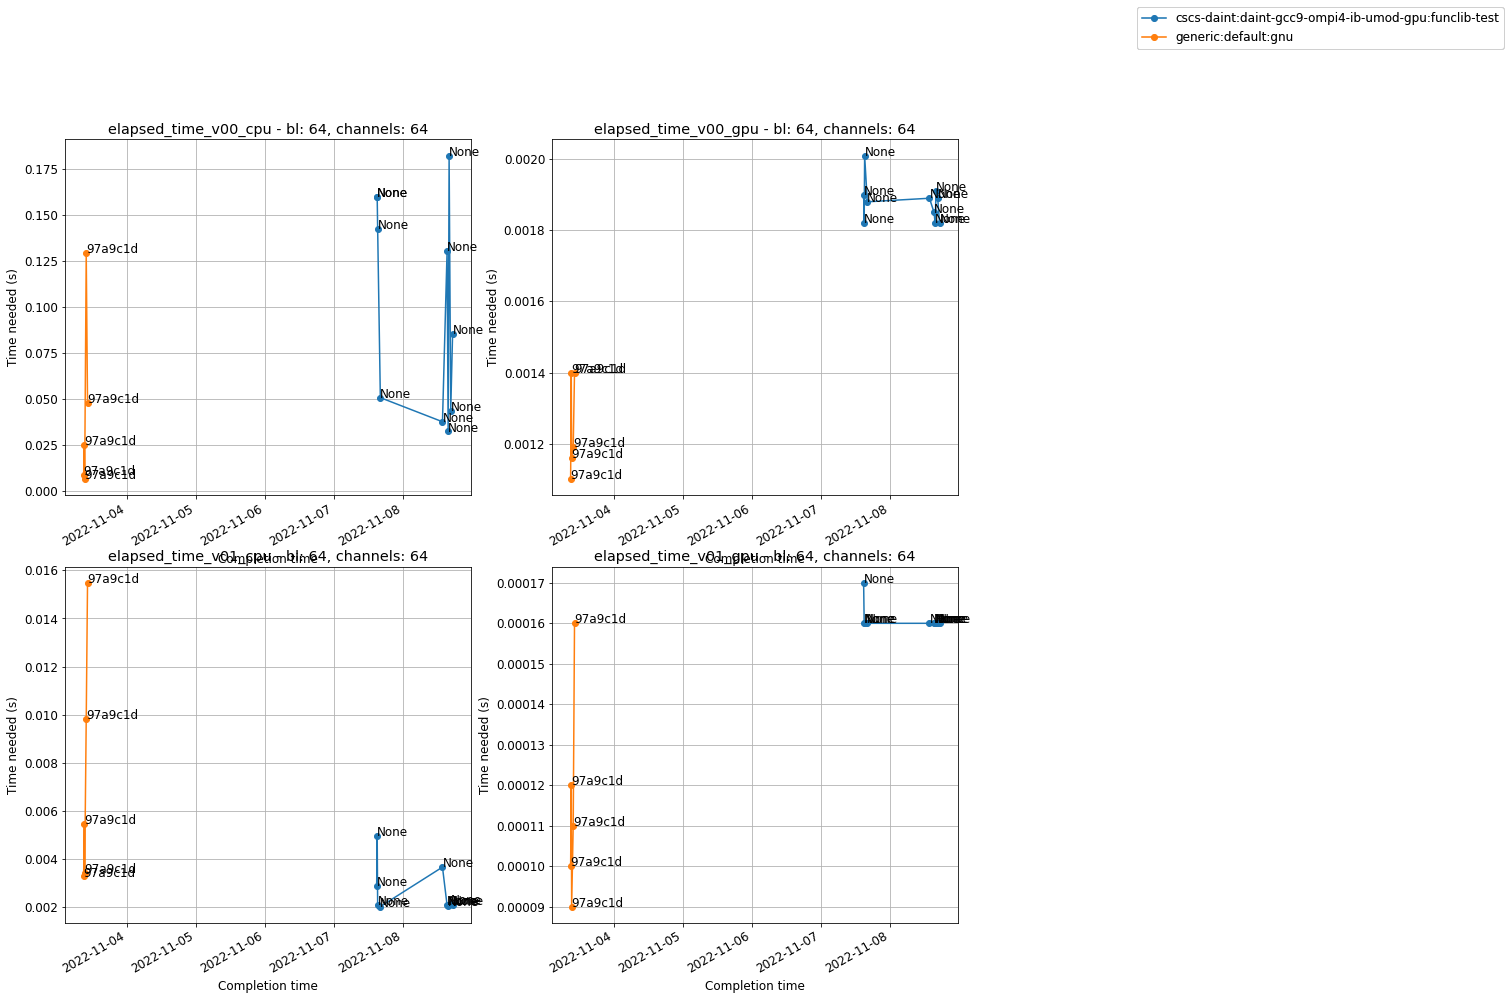

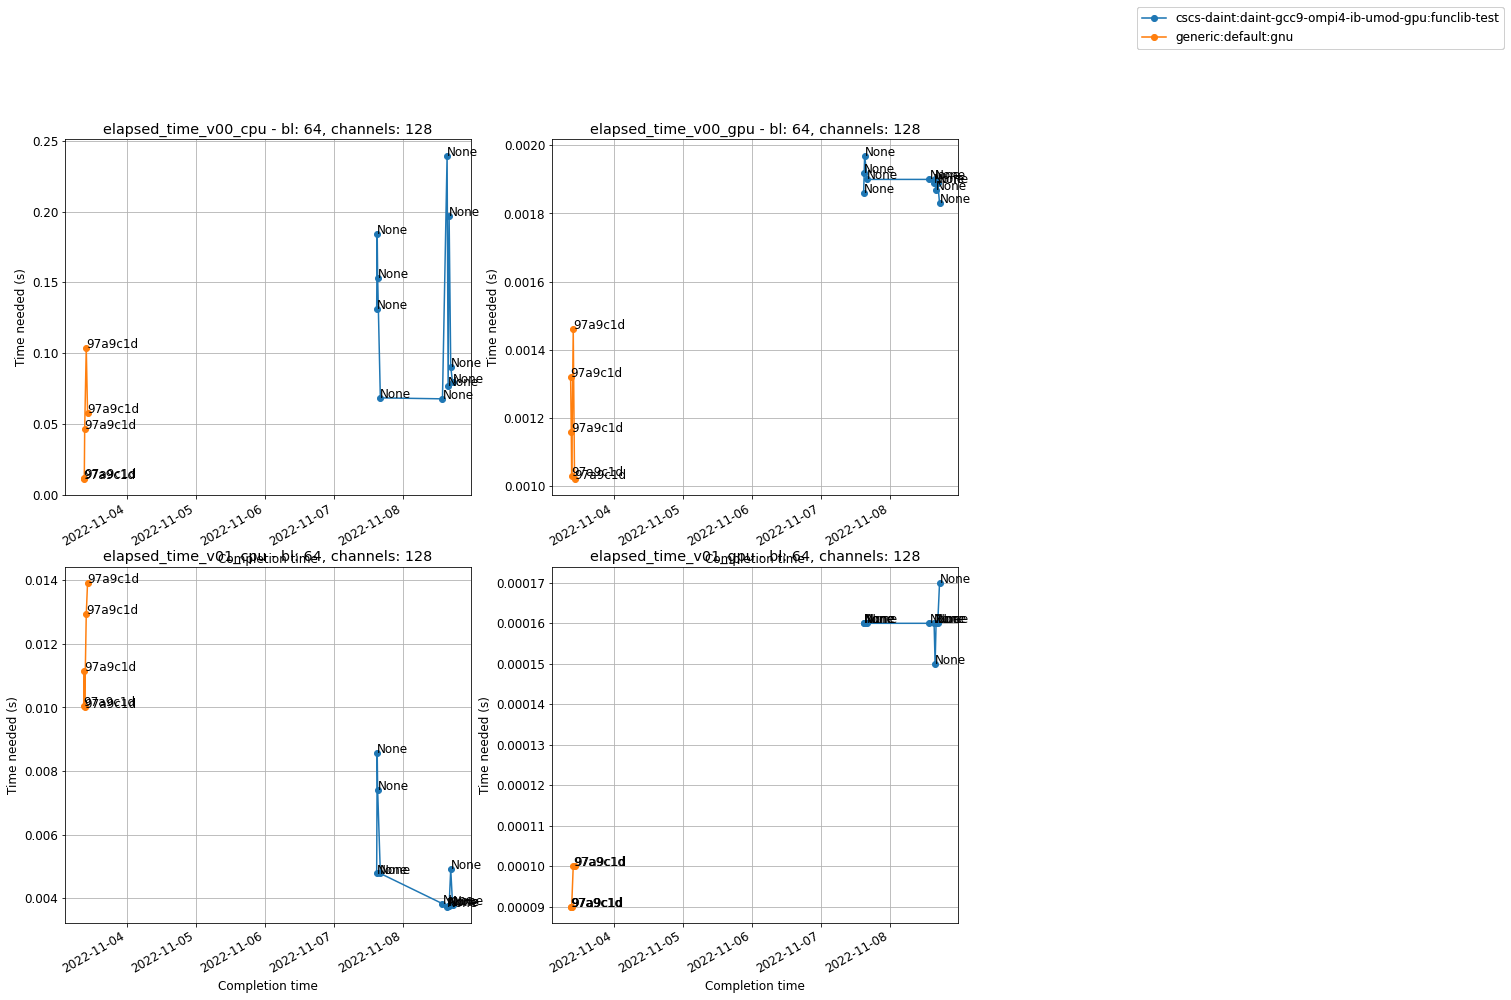

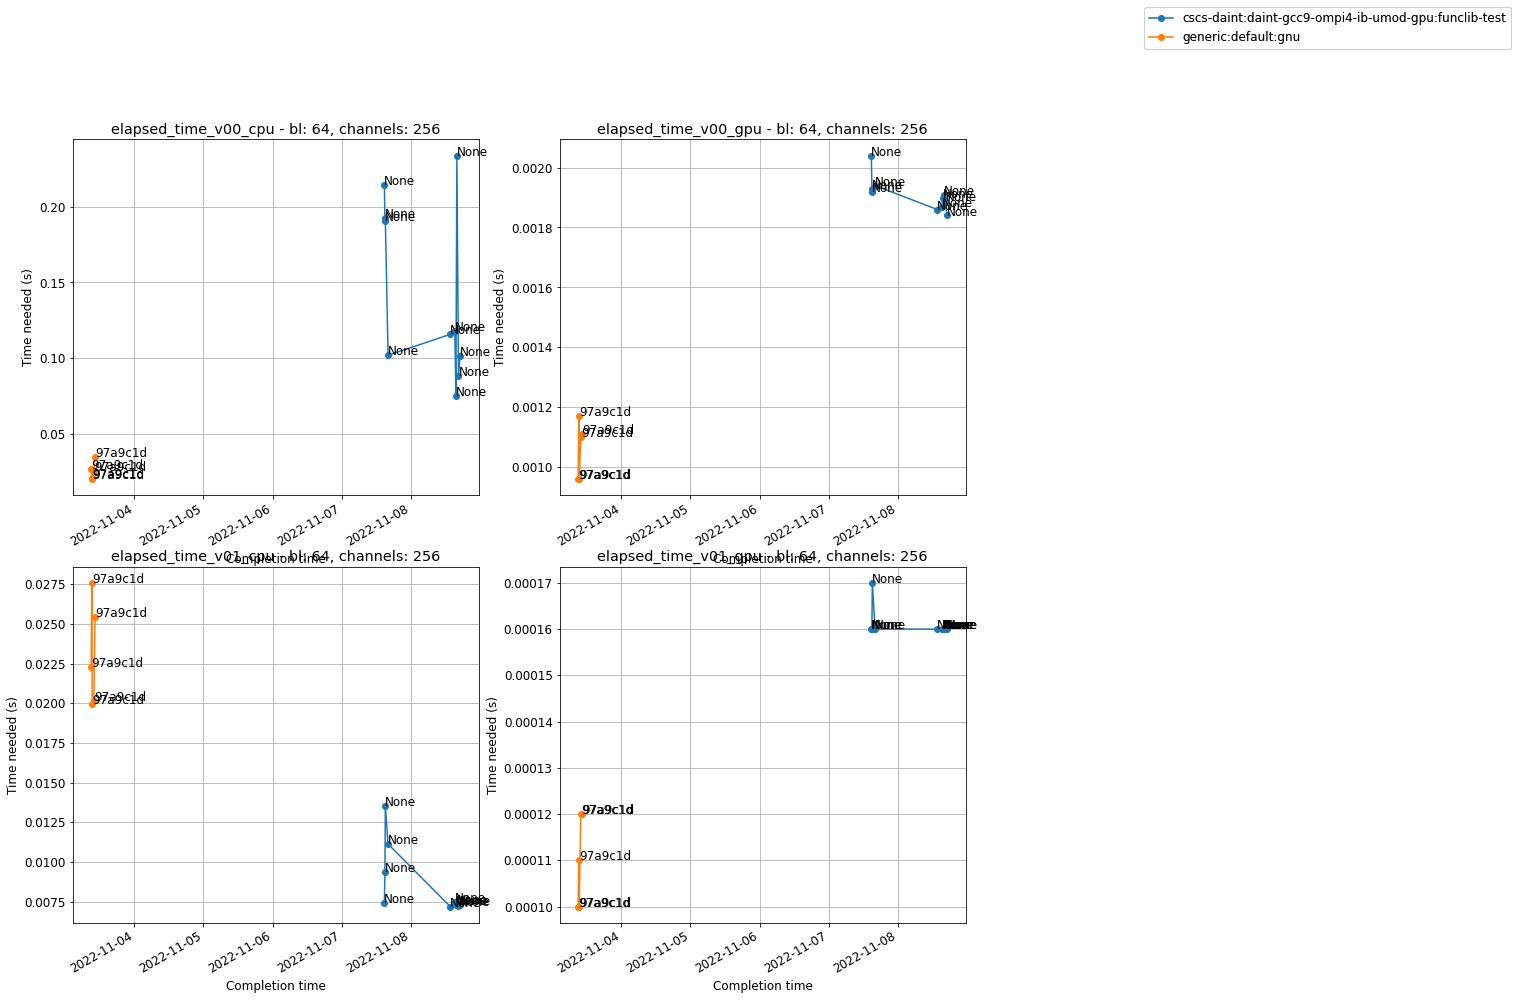

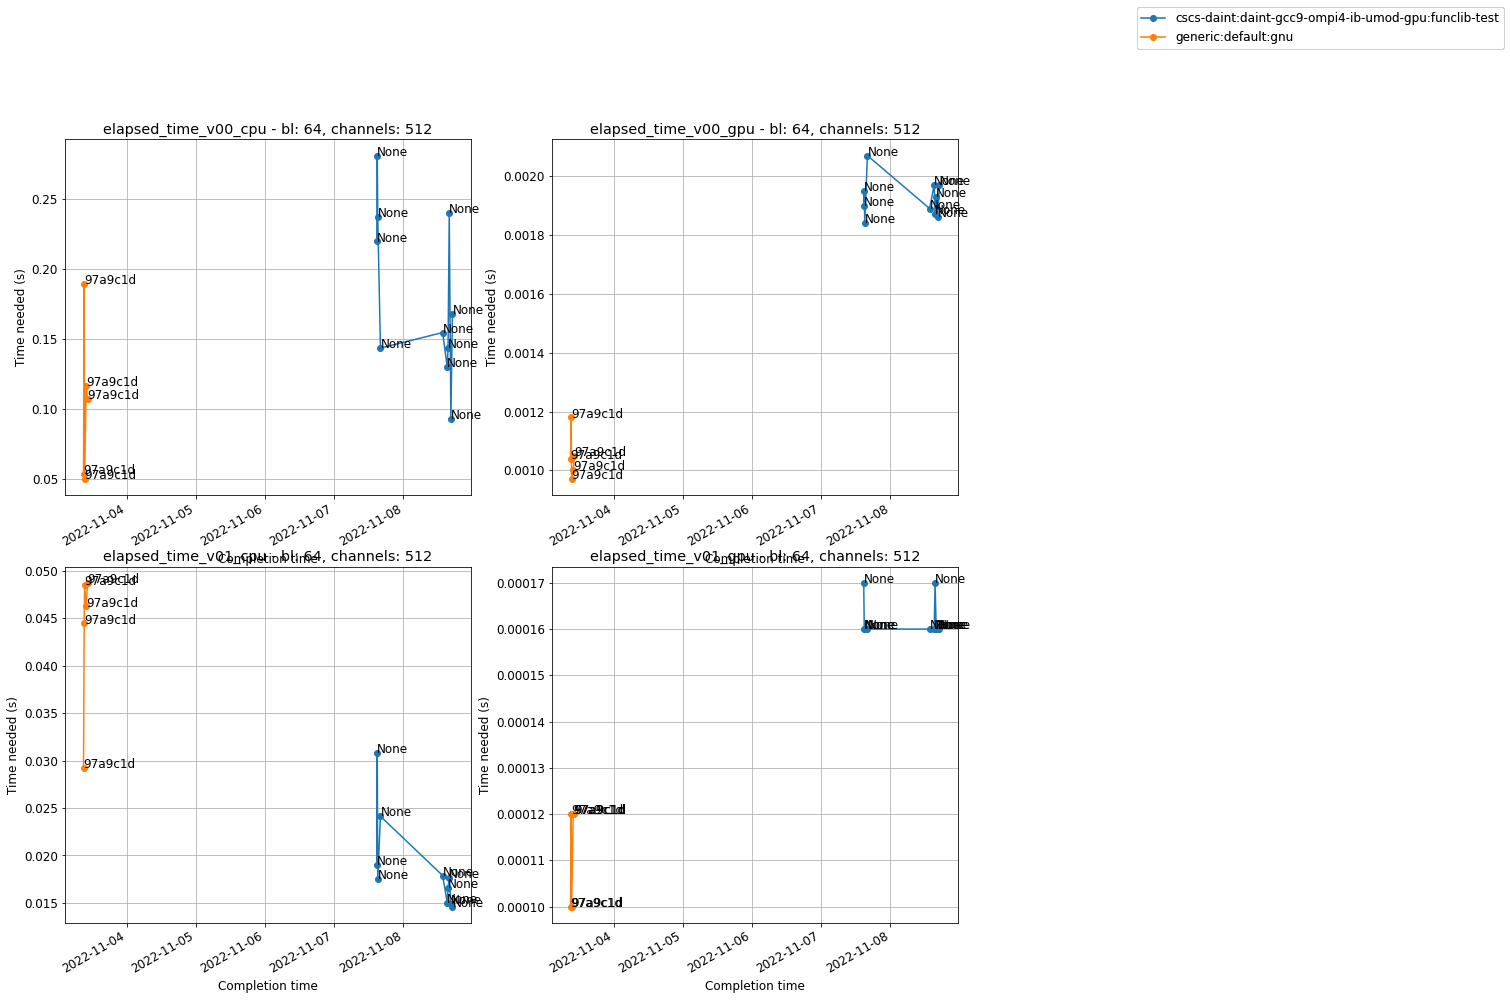

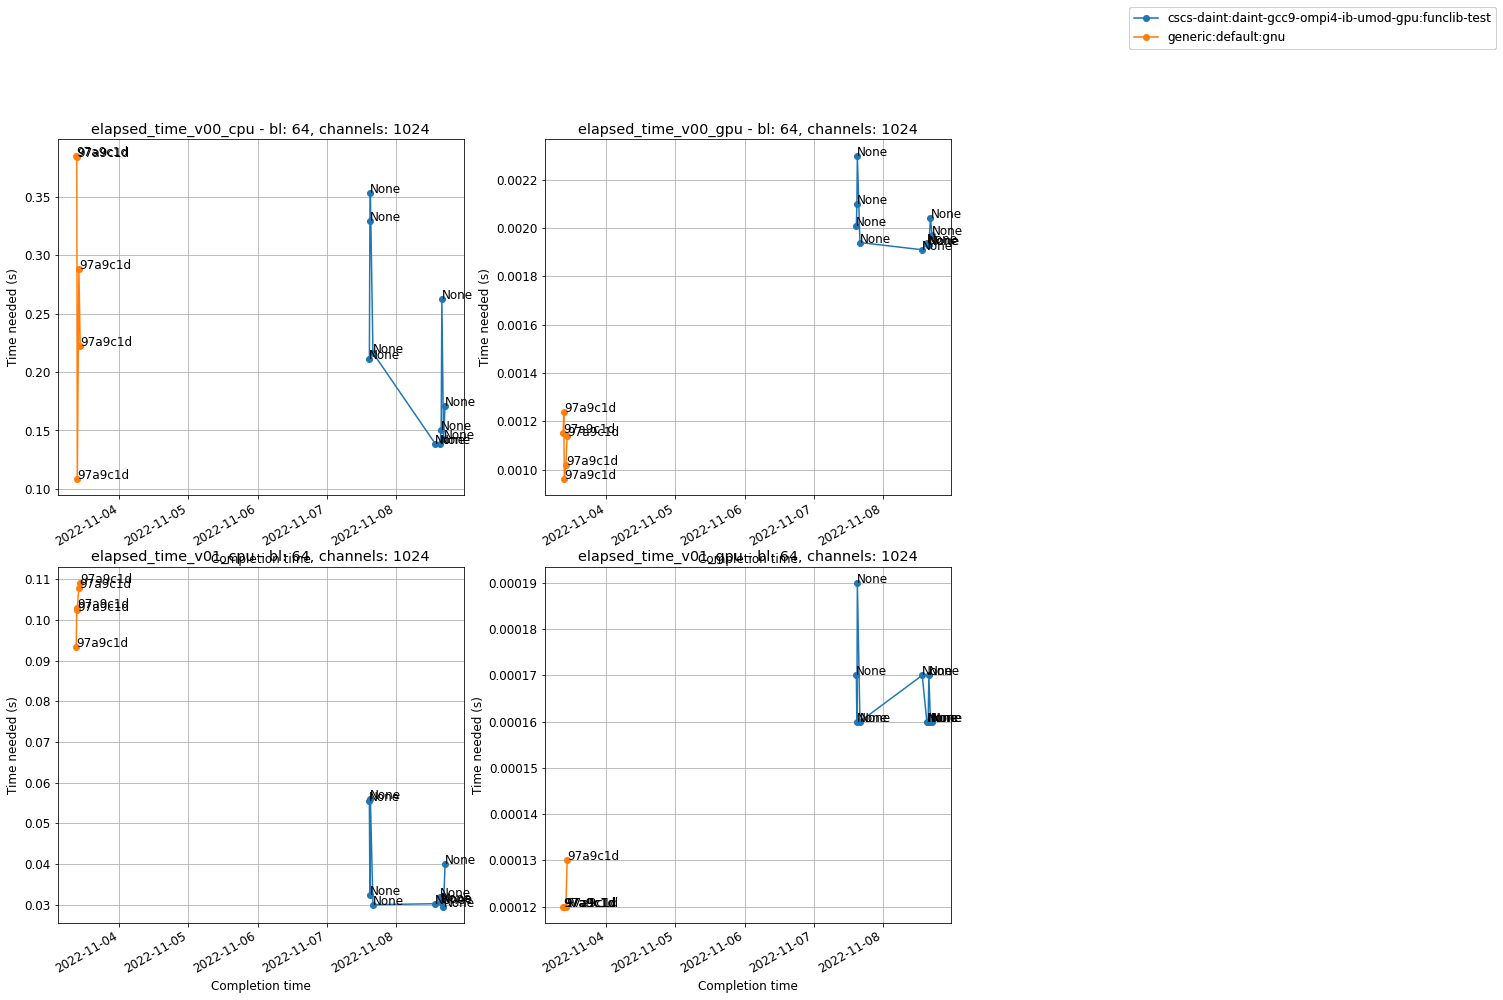

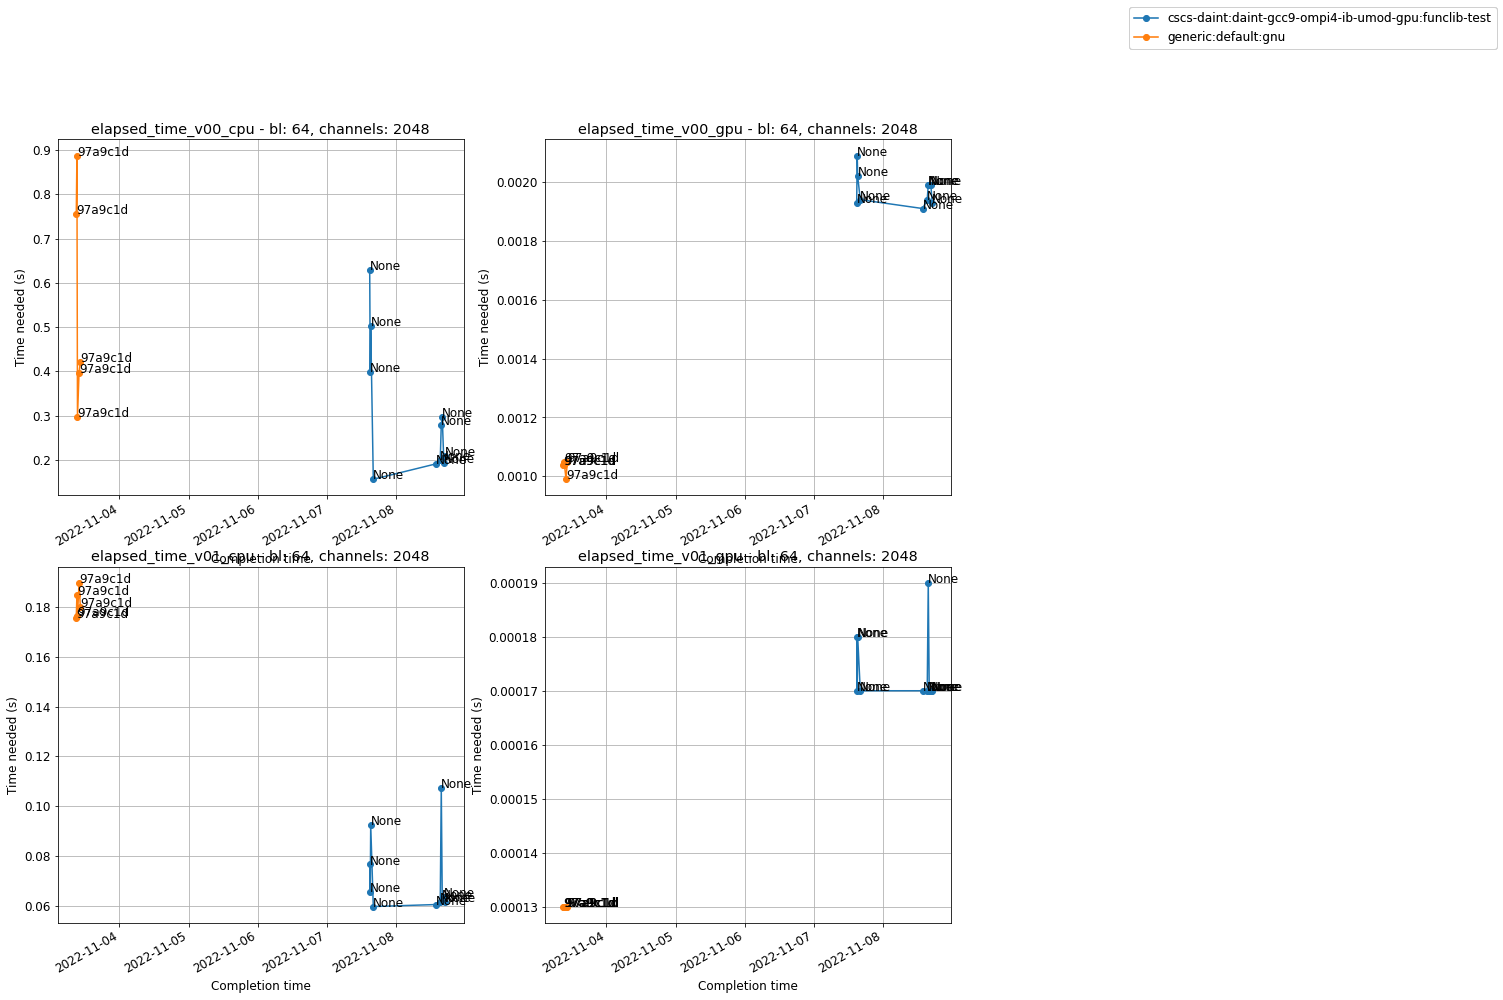

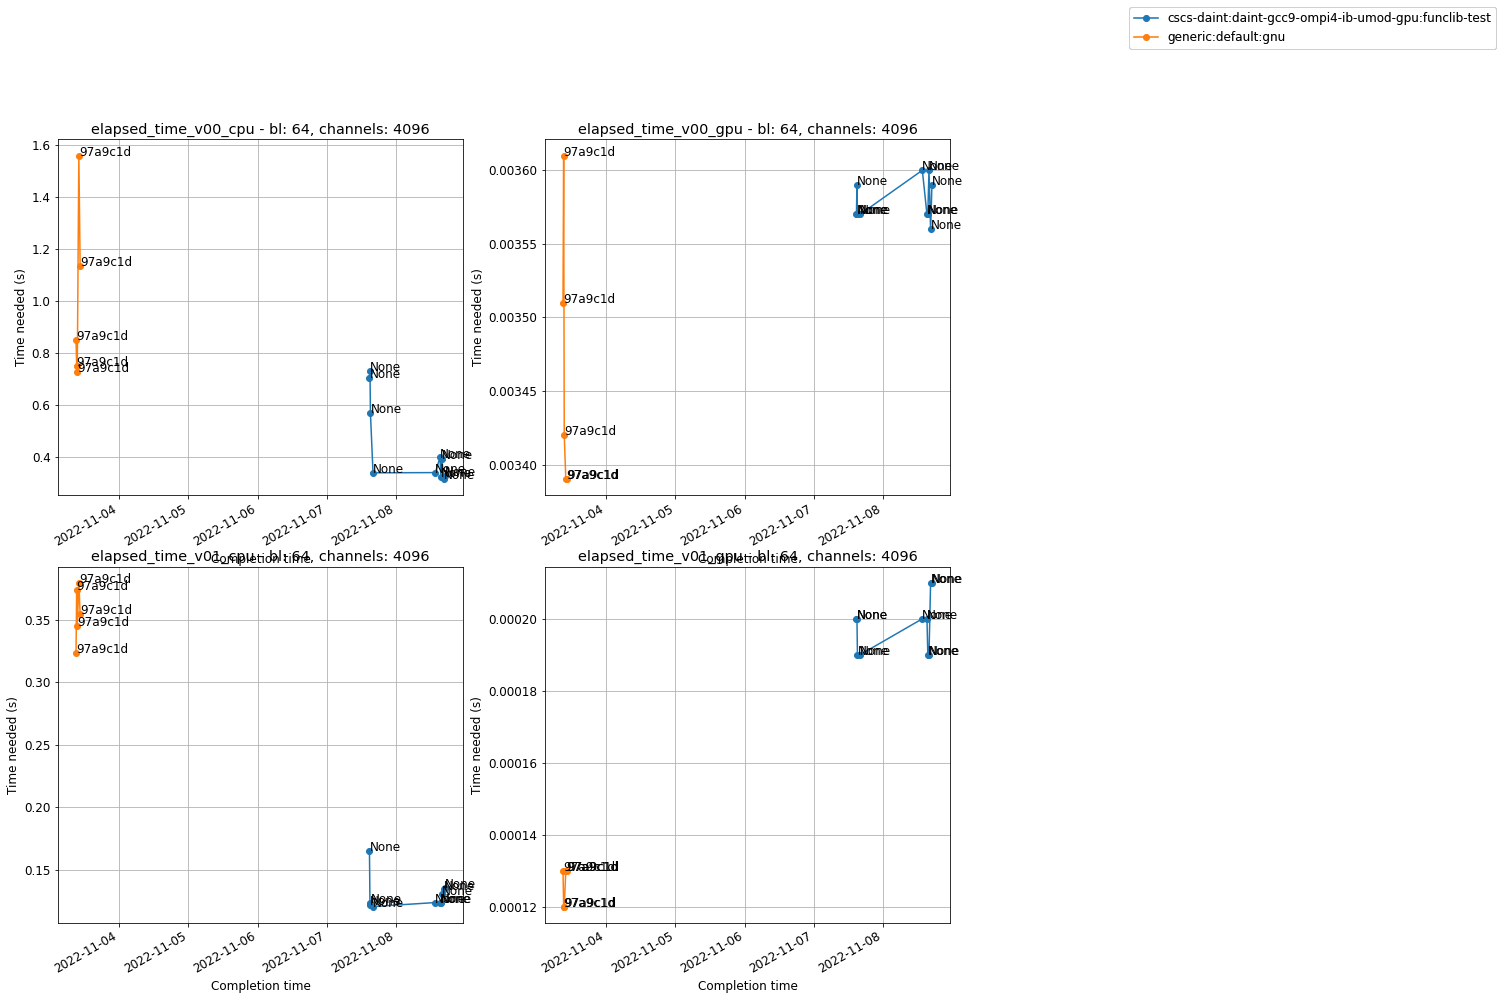

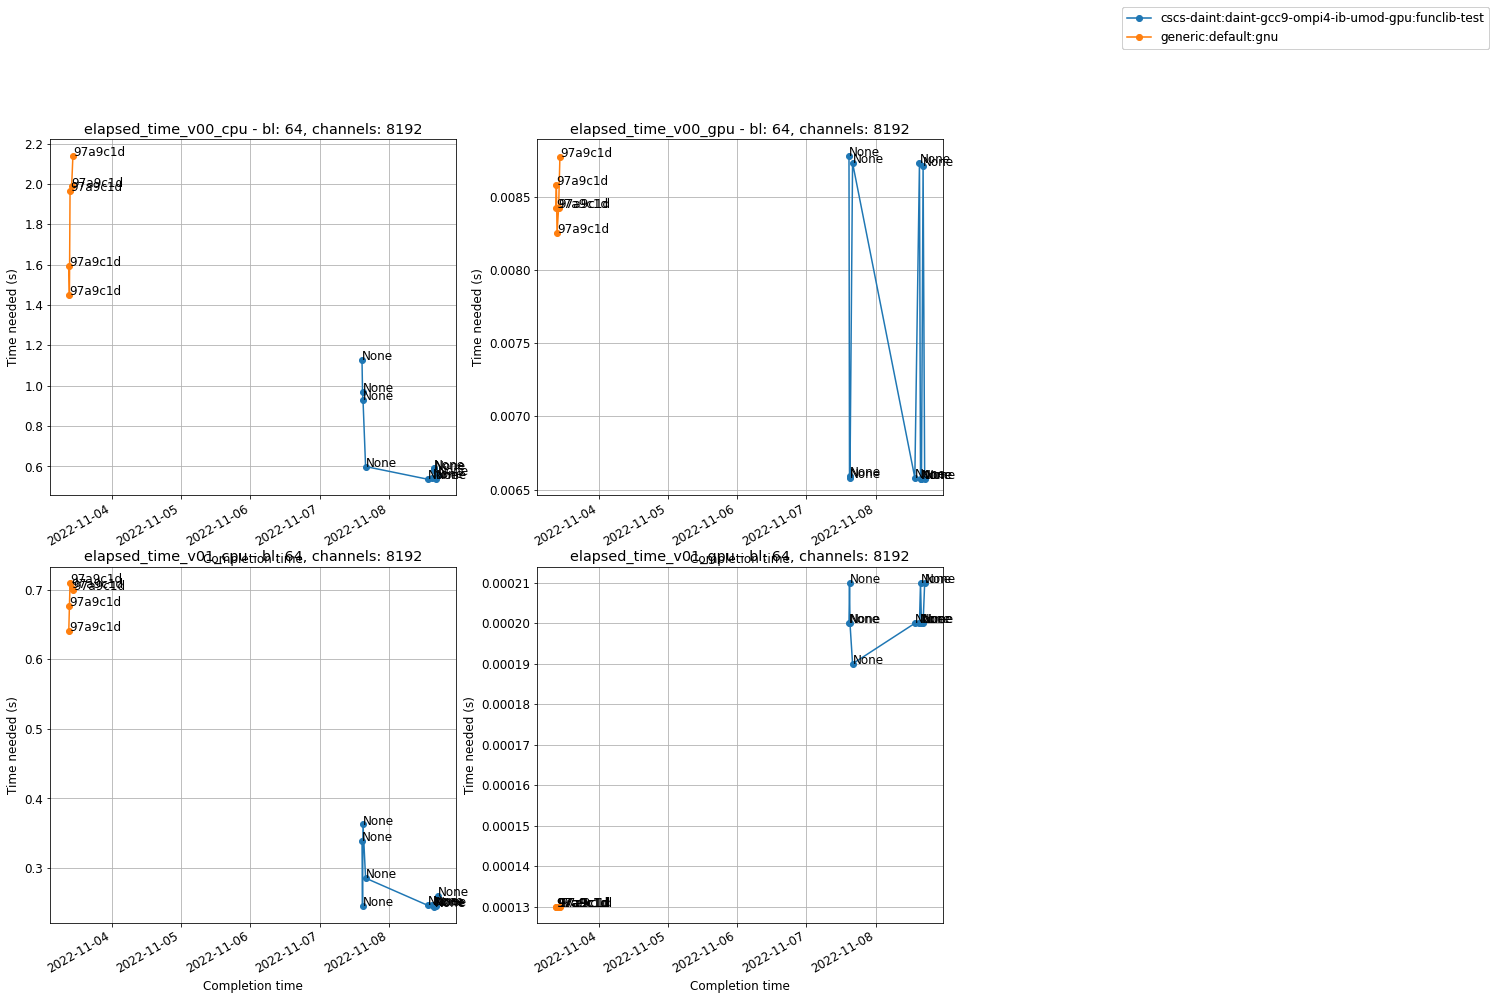

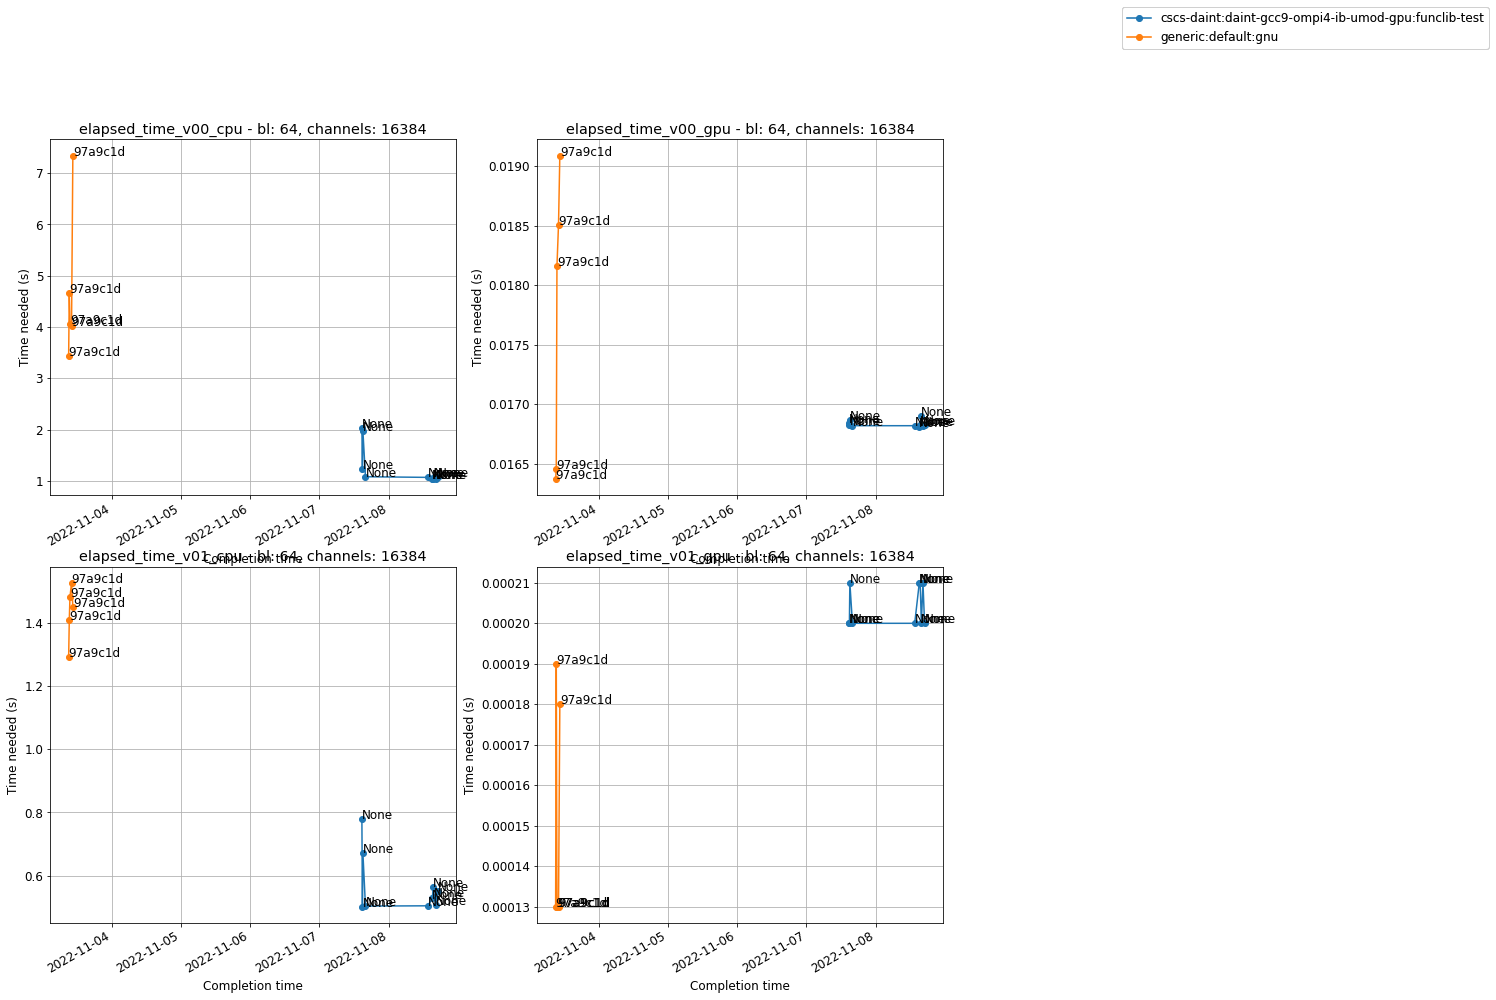

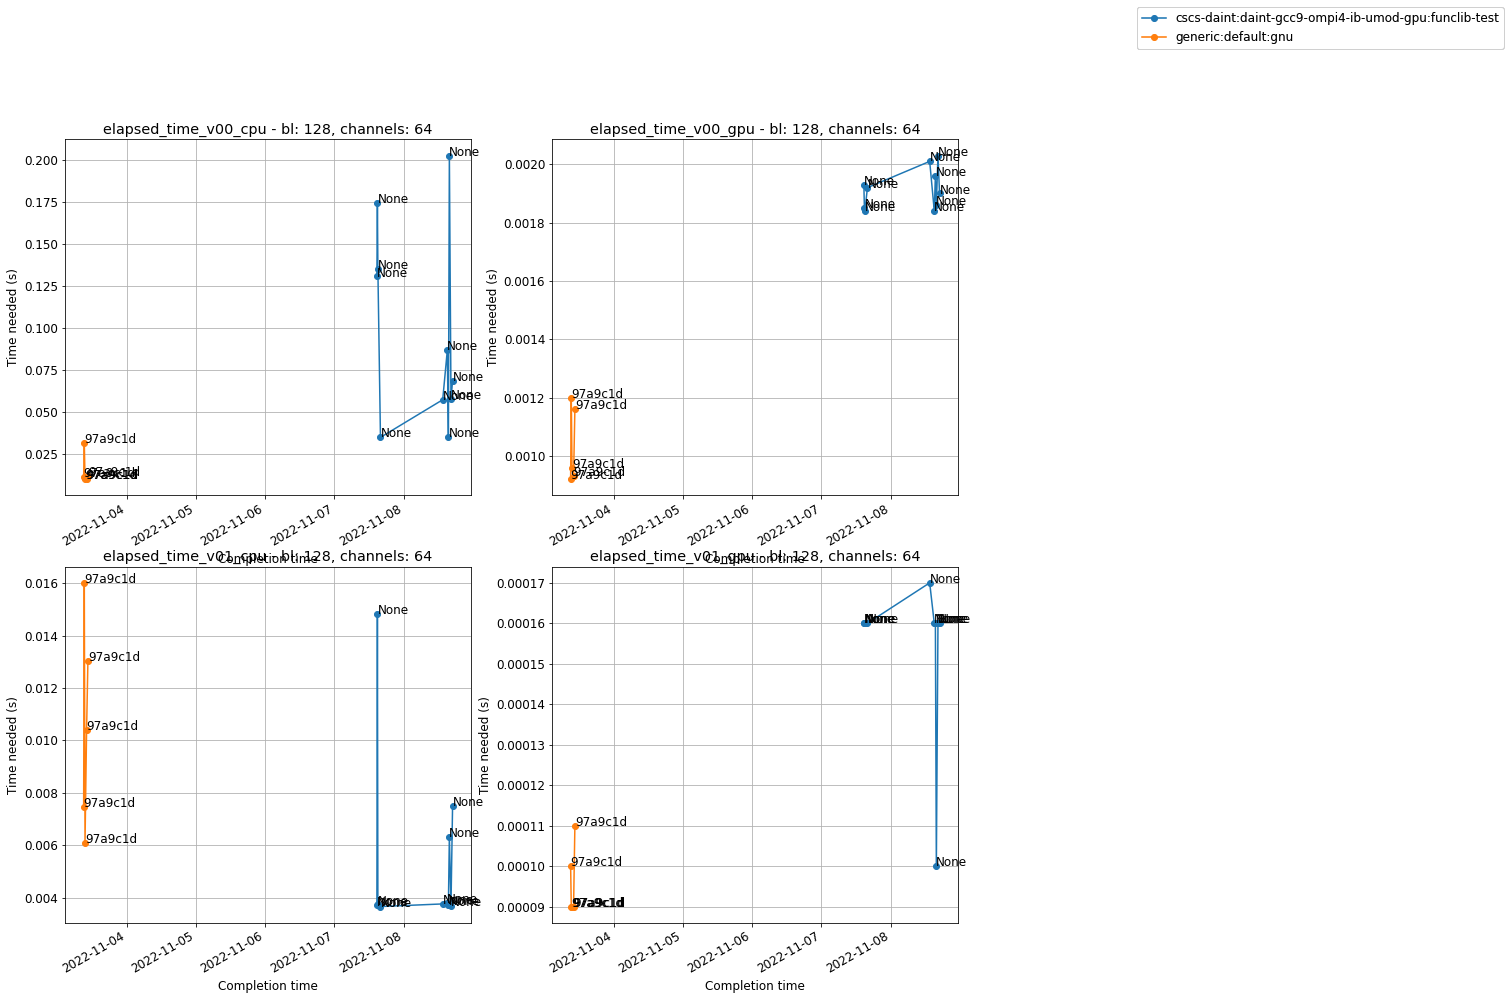

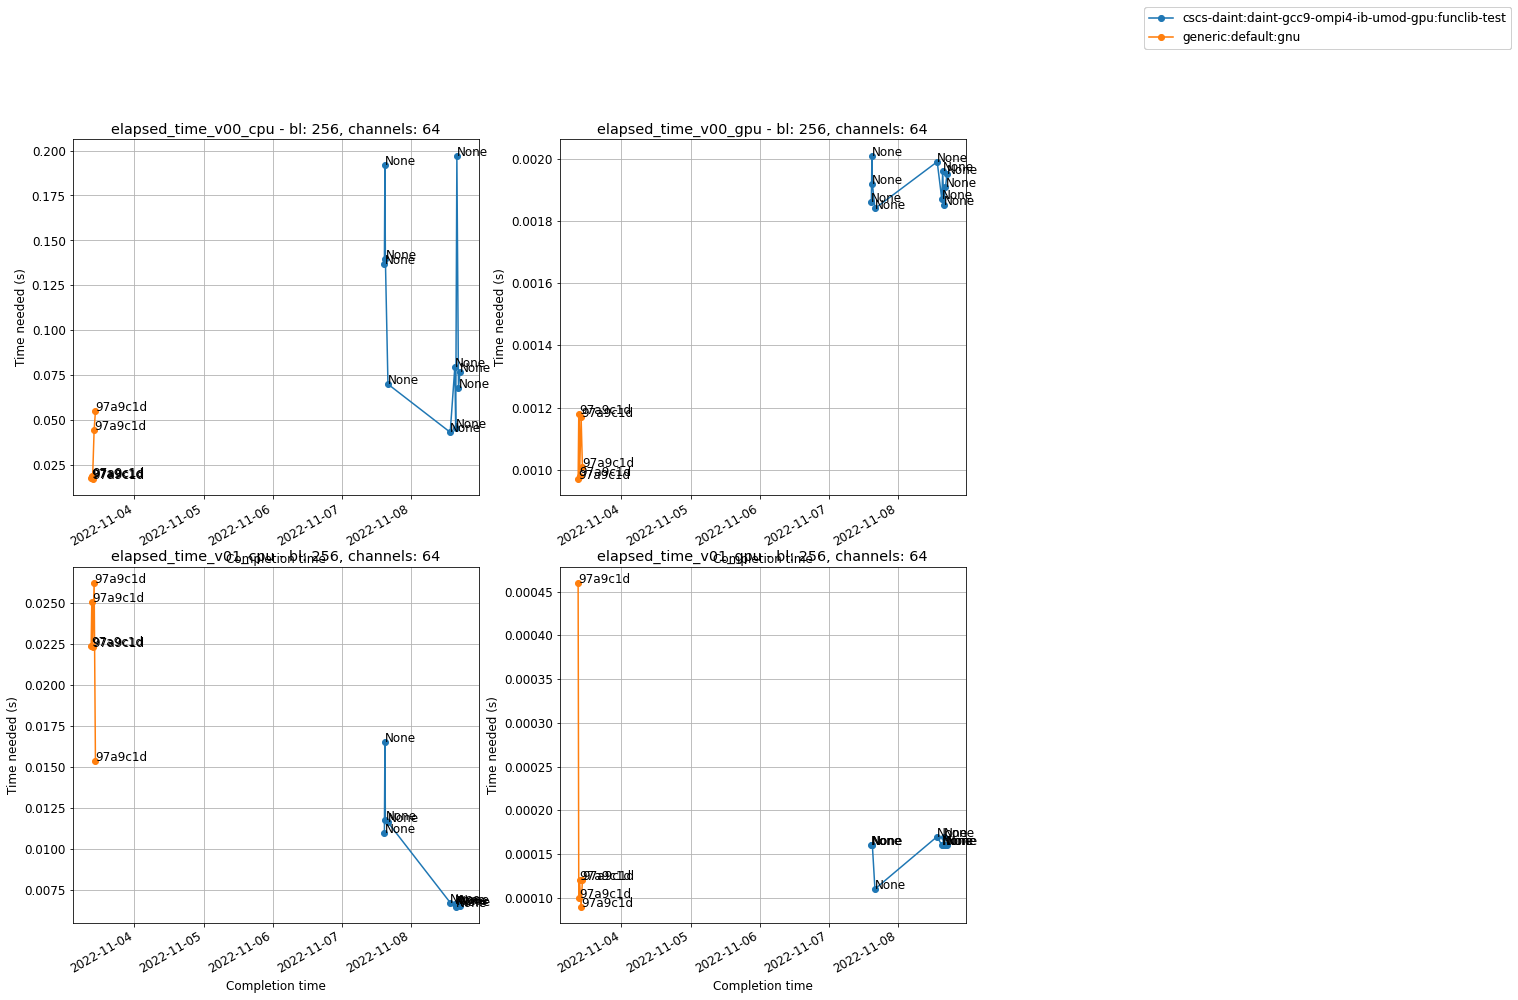

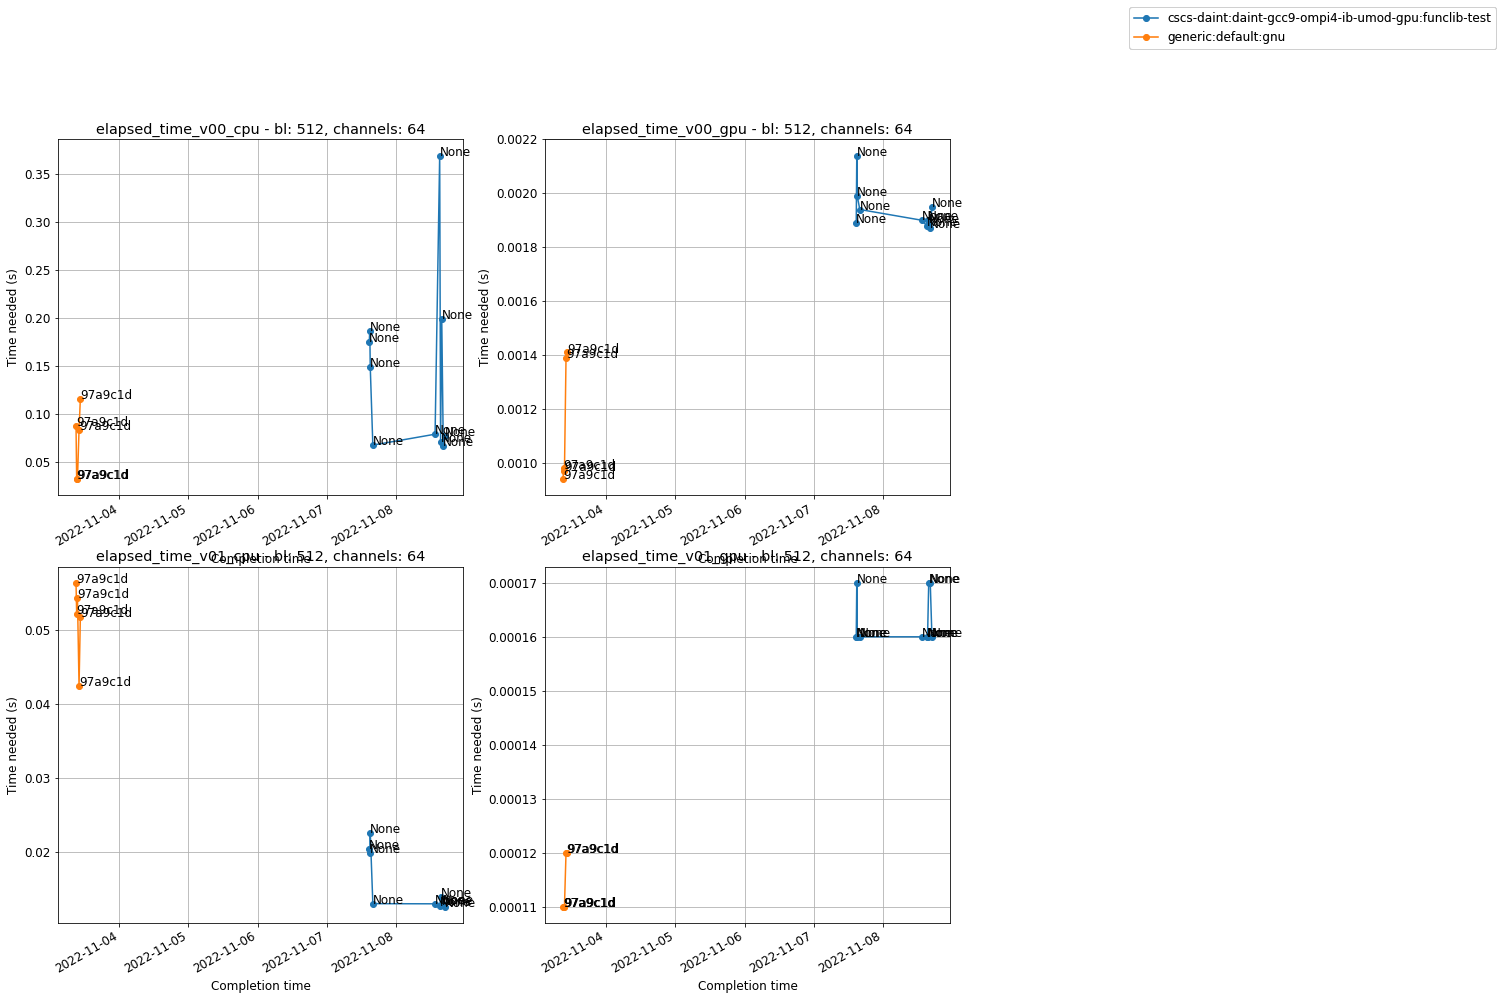

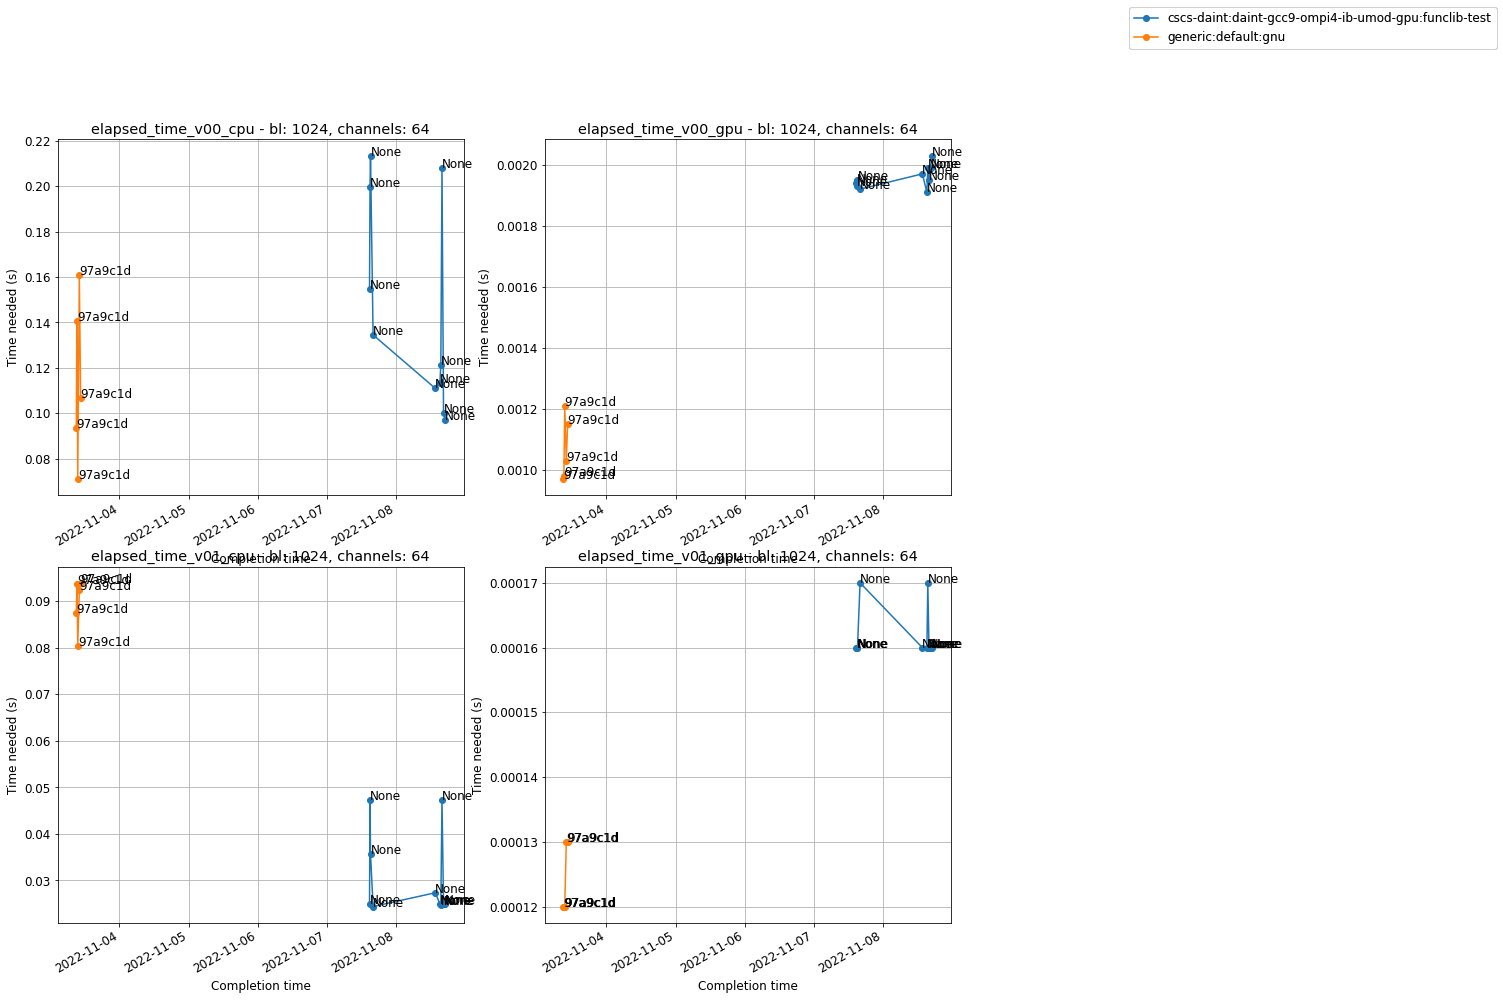

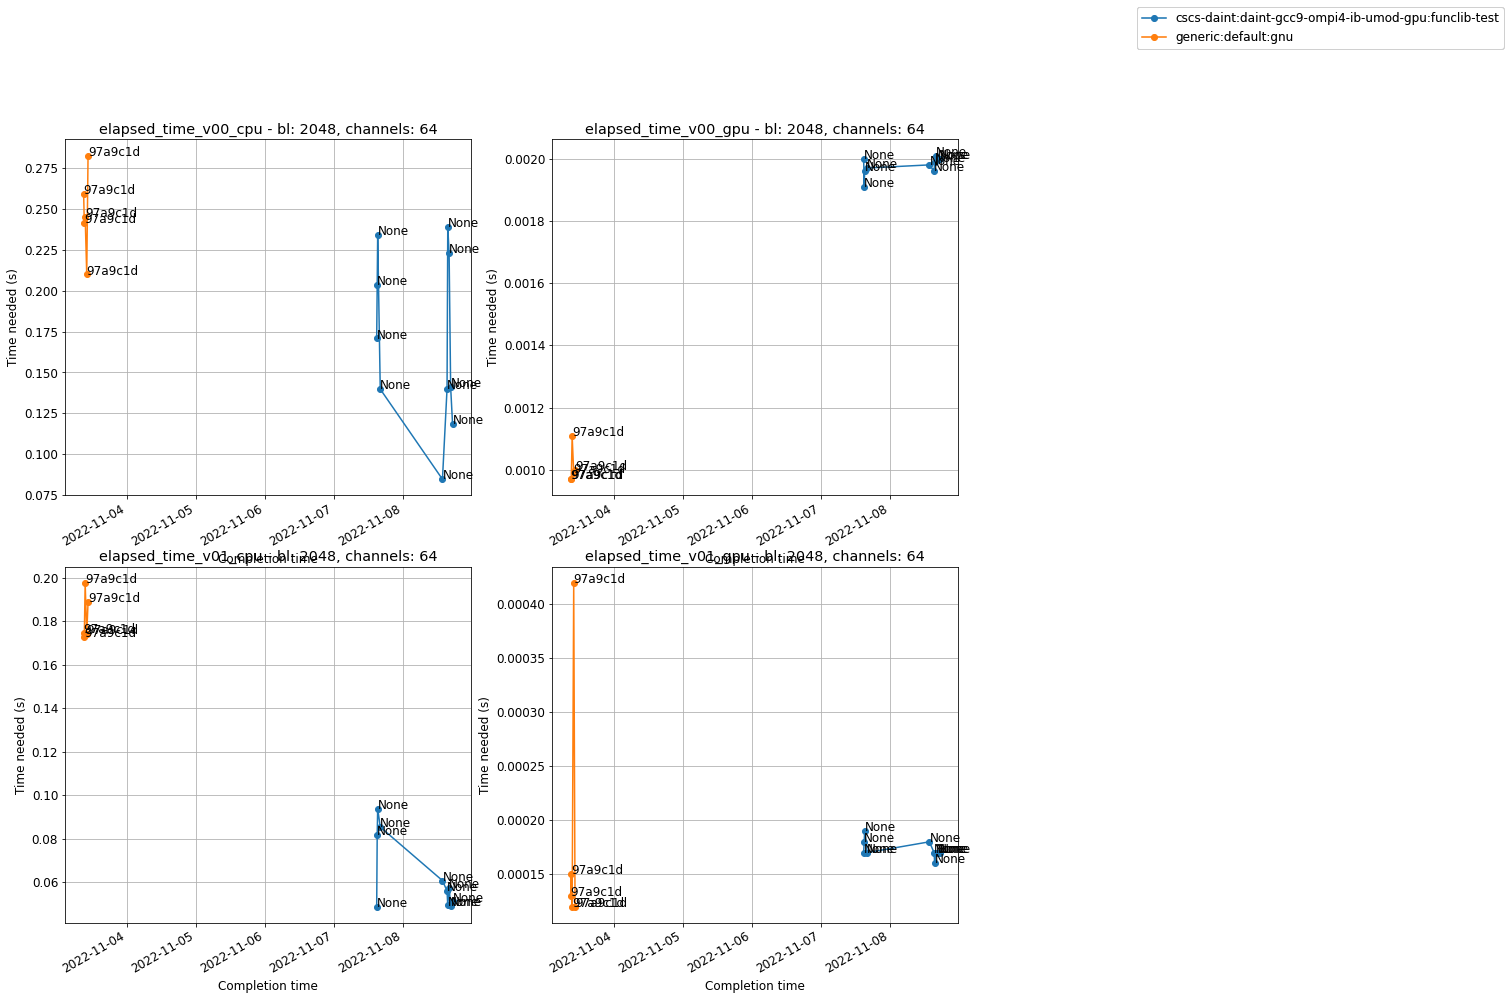

In [5]:
plt.rcParams.update({'font.size': 12})
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['baselines','channels'], test=test)
if perf_records is None:
    print('%s: no performance logs found' % test)
else:
    configs = [(64, 64), (64, 128), (64, 256), (64, 512), (64, 1024), (64, 2048), (64, 4096), (64, 8192), (64, 16384),
                      (128, 64), (256, 64), (512, 64), (1024, 64), (2048, 64)]
    for baselines, channels in configs:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
        axs = axs.flatten()
        for idx, perf_var in enumerate(perf_records['perf_var'].unique()):
            ax = axs[idx]
            for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
                data = data.loc[data['perf_var'] == perf_var]
                data = data.loc[data['baselines'] == baselines]
                data = data.loc[data['channels'] == channels]
                data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label=':'.join(spe), legend=None)

                # annotate points with git_ref:
                for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
                    if not pd.isnull(ref):
                        ax.annotate(ref[:7], (x, y))
            ax.set_title(f"{perf_var} - bl: {baselines}, channels: {channels}")
            ax.set_xlabel('Completion time')
            ax.set_ylabel('Time needed (s)')
            handles, labels = ax.get_legend_handles_labels()
            ax.grid()
            fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

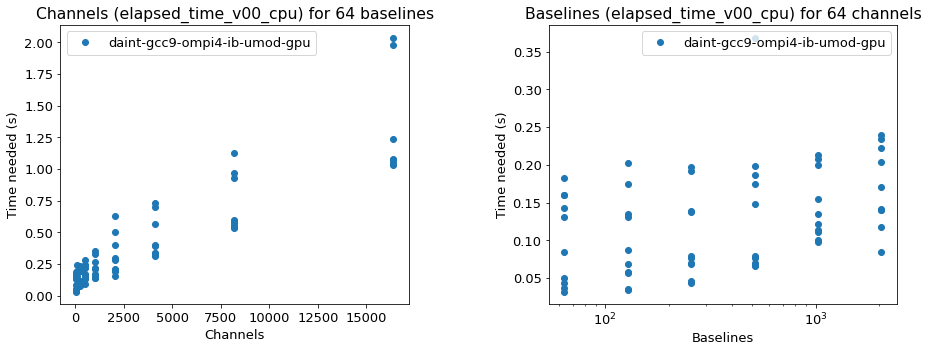

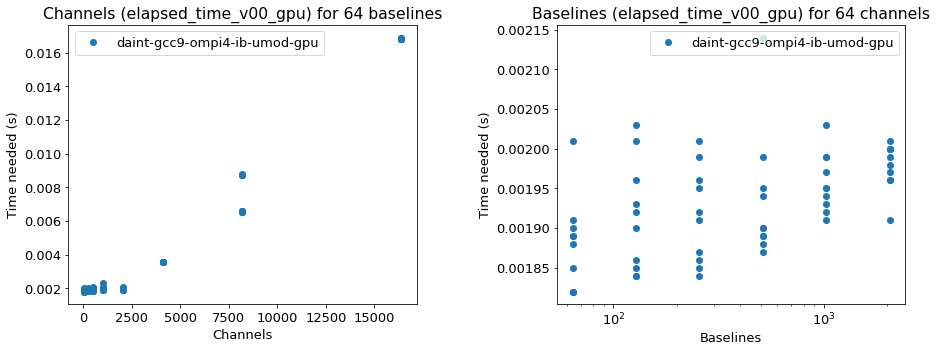

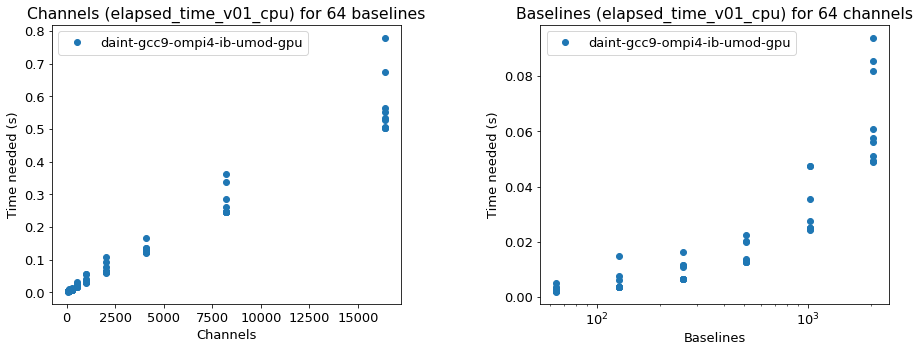

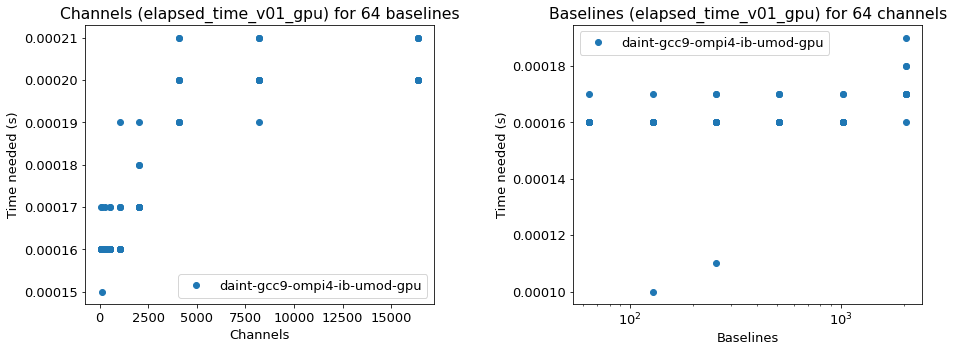

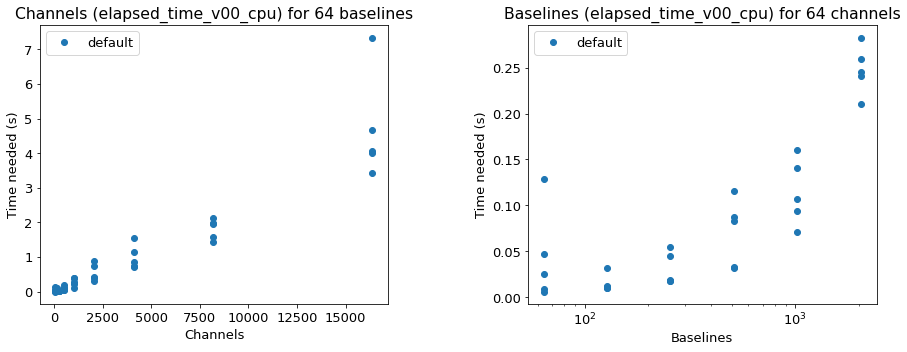

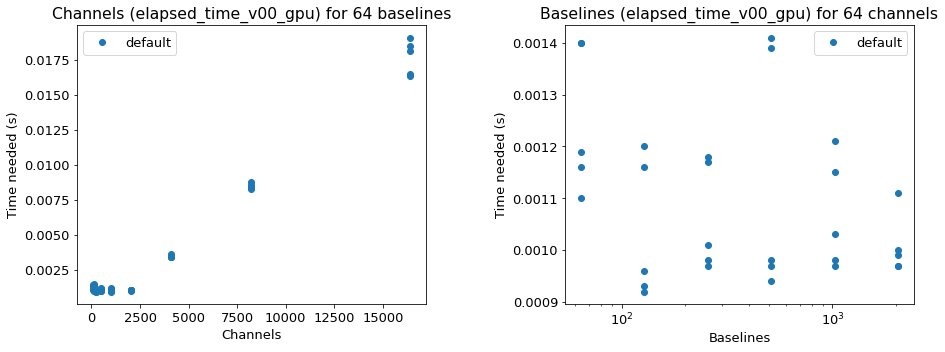

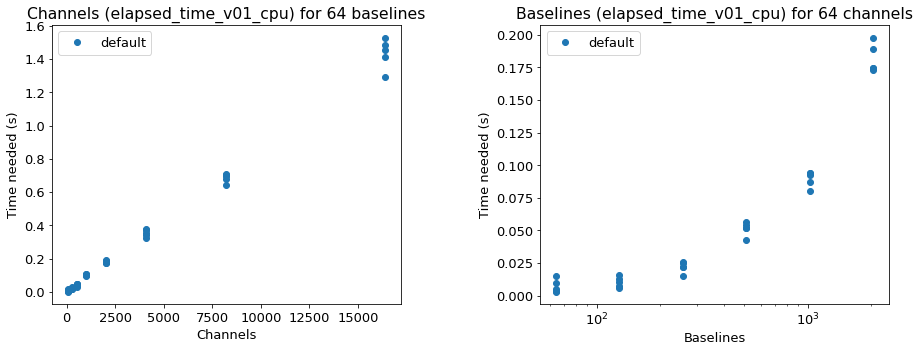

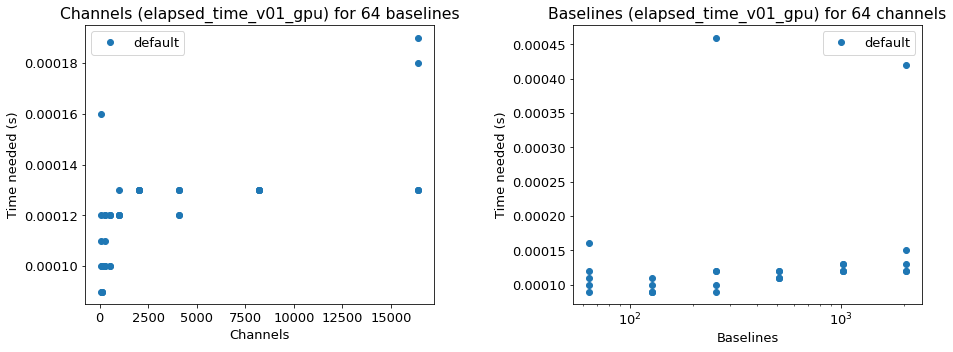

In [6]:
plt.rcParams.update({'font.size': 13})

perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, test=test, extras=['channels', 'baselines'])
if perf_records is None:
    print('%s: no performance logs found' % test)
else:
    for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):

        for idx, perf_var in enumerate(data['perf_var'].unique()):
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
            plt.subplots_adjust(top = 0.98, bottom=0.01, hspace=0.9, wspace=0.4)

            df = data.loc[data['perf_var'] == perf_var]

            # plot time needed over channels for fixed number of baselines
            baselines = 64
            df_times = df.loc[df['baselines'] == baselines]
            df_times.plot(ax=axs[0], x='channels', y=f'perf_value', style=['o'], label=f"{df.partition.unique()[0]}")
            axs[0].set_title(f"Channels ({perf_var}) for {baselines} baselines")
            axs[0].set_xlabel("Channels")
            axs[0].set_ylabel("Time needed (s)")

            # plot time needed over baselines for fixed number of channels
            channels = 64
            df_bl = df.loc[df['channels'] == channels]
            df_bl.plot(ax=axs[1], x='baselines', y=f'perf_value', style=['o'], label=f"{df.partition.unique()[0]}")
            axs[1].set_xscale('log')
            axs[1].set_title(f"Baselines ({perf_var}) for {channels} channels")
            axs[1].set_xlabel("Baselines")
            axs[1].set_ylabel("Time needed (s)")

        plt.show()